In [1]:
import torch
from models import GLOM
from datamodules import MNISTDataset
import matplotlib.pyplot as plt
import yaml
from einops import repeat
import numpy as np
import random
from torch.nn.functional import mse_loss
import wandb
import os
from einops.layers.torch import Rearrange

np.set_printoptions(suppress=True)

# Load a batch of images and a model

In [2]:
# Get dataloader, generate a batch
dm = MNISTDataset(data_dir=os.environ['SCRATCH']+'/datasets', batch_size=32)
dm.setup(stage='test')
dataloader = dm.test_dataloader()
clean, corrupt = next(iter(dataloader))[0]

In [3]:
# Load checkpoint with appropriate config, print config
run = wandb.init()
artifact = run.use_artifact('leogagnon/GLOM/model-26ii3vso:v7', type='model')
glom = GLOM.load_from_checkpoint(os.path.join(artifact.download(),'model.ckpt'));
run.finish(quiet=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leogagnon. Use `wandb login --relogin` to force relogin


In [4]:
# Run the batch of data through the model, compute loss
embedding = glom.encoder(corrupt)

state = repeat(glom.init_column, 'l d -> b n l d', b=embedding.shape[0], n=embedding.shape[1])
for _ in range(5):
    state, latent_recon, (bu, td, lat) = glom.forward(embedding, state)

reconstruction = glom.decoder(latent_recon).detach()
state = state.detach()

float(mse_loss(reconstruction, clean))

0.022317474707961082

In [8]:
glom.hparams

"add_embedding":          False
"contributions":          [0.15, 0.55, 0.15, 0.15]
"hidden_dim":             20
"image_shape":            [1, 28, 28]
"iters":                  5
"latent_reconstruction":  False
"levels":                 2
"local_coeff":            0.1
"local_consensus_radius": 0
"local_loss":             True
"location_embedding":     True
"num_patch_side":         7
"optimizer_args":         {'lr': 0.05, 'decay': 0.0005, 'steps_per_epoch': 46, 'epochs': 50}
"overlapping_embedding":  False
"recon_coeff":            1.0
"reconstruction_end":     True

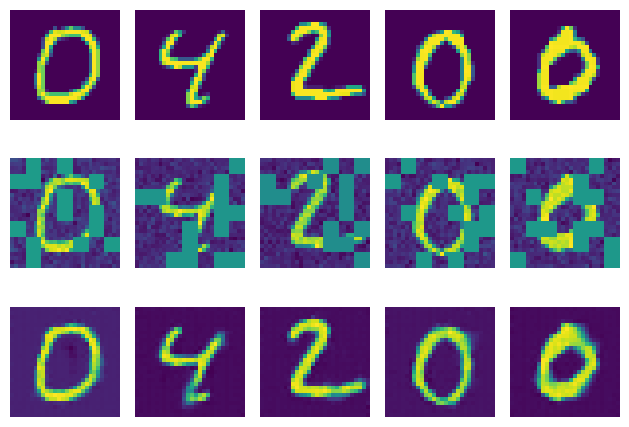

In [7]:
# Print random samples
idx = random.sample(list(np.arange(len(clean))), 5)
show_image_grid(clean[idx], corrupt[idx], reconstruction[idx], grid=False)

# Useful functions

In [18]:
# Prints a grid of images, with or without patch grids
def show_image_grid(*image_rows, grid=False):
    images_rows = [np.array(row) for row in image_rows]
    n = len(images_rows)
    m = len(images_rows[0])
    fig, axes = plt.subplots(n,m)
    for i in range(n):
        for j in range(m):
            im = axes[i,j].imshow(images_rows[i][j].squeeze())
            if grid:
                axes[i,j].set_xticks(np.arange(0,28,4))
                axes[i,j].set_yticks(np.arange(0,28,4))
                axes[i,j].grid(color='white', linestyle='-', lw=2)
                for tick in axes[i,j].xaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
                for tick in axes[i,j].yaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
            else:
                axes[i,j].axis('off')
            fig.colorbar(im)

                
            
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()

# Turns a batch of images into patches
patchify = torch.nn.Sequential(
    torch.nn.Unfold(kernel_size=(4,4), stride=(4,4)),
    Rearrange('b (h w) (H W) -> b H W h w', h=4, w=4, H=7, W=7)
    )

TypeError: colorbar() missing 1 required positional argument: 'mappable'

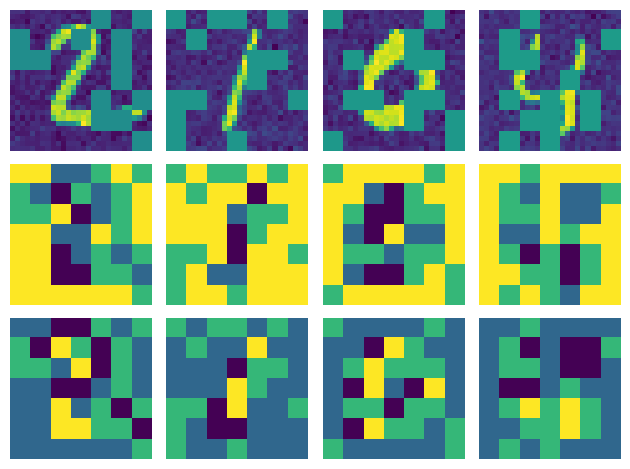

In [19]:
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch

clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
#clustering = KMeans(n_clusters=3)
#clustering = Birch(threshold=0.005, n_clusters=2)

labels = []

for i in range(2): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    clusters = clustering.fit(samples)
    labels.append(clusters.labels_)

show_image_grid(corrupt[1:5], labels[0].reshape((32,7,7))[1:5], labels[1].reshape((32,7,7))[1:5])

In [9]:
patches = patchify(clean)
patches_label = [patches[(labels[1]==i).reshape((32,7,7))] for i in range(50)]

NameError: name 'labels' is not defined

In [30]:
patches_label[3].shape

torch.Size([6, 4, 4])

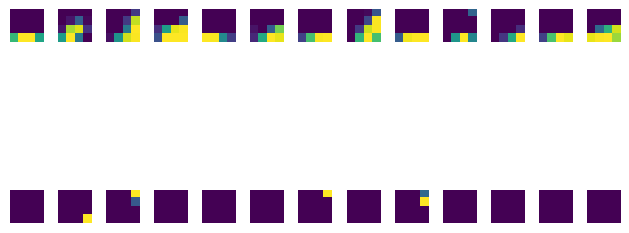

In [33]:
show_image_grid(patches_label[3], patches_label[4])

[0.41741401 0.12881932 0.072864   0.06196588 0.05604796 0.05016849
 0.04087406 0.02874    0.02597746 0.02049779 0.01885232 0.01619211
 0.0145579  0.0127045  0.01184944 0.00747606 0.00563974 0.00447716
 0.00382026 0.00106153]
[0.24141951 0.14658033 0.13367551 0.08943665 0.07177147 0.05842477
 0.05319736 0.04116869 0.03129586 0.02831389 0.02556194 0.01936466
 0.01725942 0.0112522  0.00914016 0.00712321 0.00566202 0.00425477
 0.00301258 0.00208501]


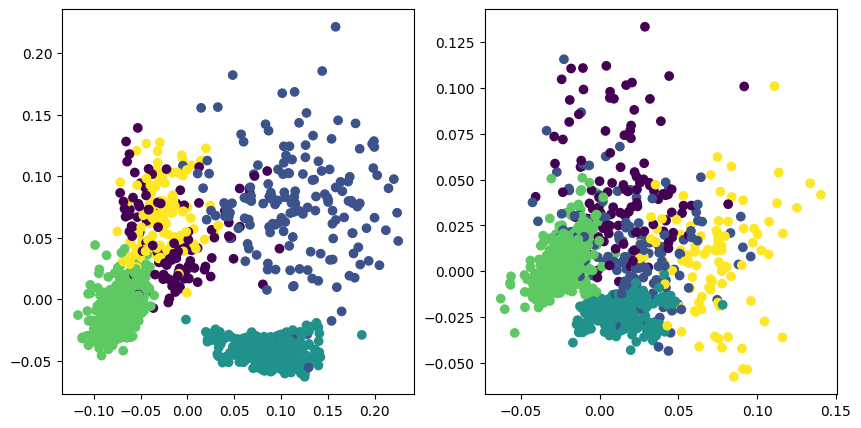

In [50]:
from sklearn.decomposition import PCA

pca = PCA()
pc_layer = []

for i in range(2): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    pc = pca.fit(samples)
    print(pc.explained_variance_ratio_)
    pc_layer.append(pc.transform(samples))

fig, axes = plt.subplots(1,2, figsize=(10,5))

for i in range(2):
    axes[i].scatter(pc_layer[i][:,0],pc_layer[i][:,1],c=labels[i])


/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


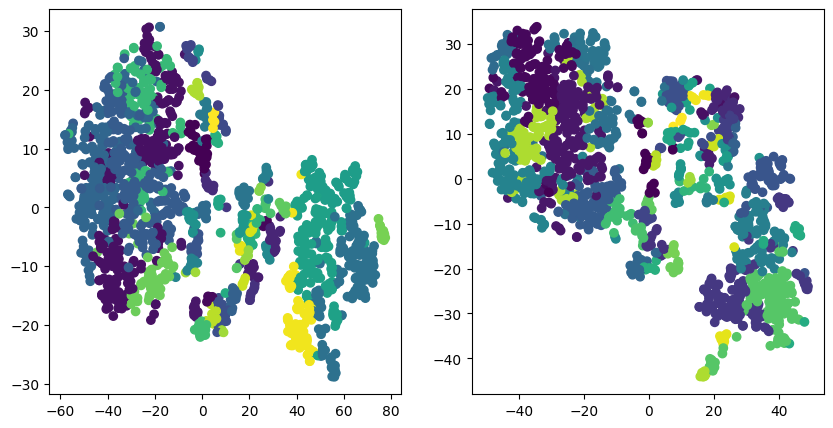

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
tsne_layer = []

for i in range(2): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    tsne_layer.append(tsne.fit_transform(samples))

fig, axes = plt.subplots(1,2, figsize=(10,5))

for i in range(2):
    axes[i].scatter(tsne_layer[i][:,0],tsne_layer[i][:,1],c=labels[i])


In [188]:
import wandb
run = wandb.init()
artifact = run.use_artifact('leogagnon/GLOM/model-3pv4s3oj:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leogagnon. Use `wandb login --relogin` to force relogin


In [189]:
run.kil

'./artifacts/model-3pv4s3oj:v0'